<a href="https://colab.research.google.com/github/TineClaeys/Master-2-AISD---Projet-transdiciplinaire/blob/main/Tissue_prediction_ML_course.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Basic introduction to machine learning through tissue prediction

**What are proteins?**   
Proteins are the active components of the human body, responsible for carrying out the functions that define how our tissues operate. They are produced through the translation of DNA, which encodes the instructions for building these molecules. Essentially, proteins are the workers of the body—enabling everything from muscle contraction to signaling in the brain.  
  

**Tissue specificity of proteins**   
While some proteins are present in nearly every tissue, ensuring basic functions like energy production, others are highly specific to certain tissues. For example, muscle tissue has unique proteins that enable contraction, while liver tissue has specialized proteins for detoxification. This tissue-specific expression of proteins helps define the specialized roles of each organ.  
  

**Why train a model on these patterns?**     
By training a machine learning model on healthy protein expression patterns across tissues, we can teach it to classify samples based on these distinctive protein signatures. This approach becomes even more interesting when applied to disease data. If the model is confused when classifying diseased tissues, it may reveal disruptions in protein expression—providing insights into the disease mechanisms and potentially aiding in diagnostics.

First we start with importing the necessary packages and modules to be able to run the scripts

In [1]:
import pandas as pd
import numpy as np
import pickle
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
import time

from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
from sklearn.model_selection import RandomizedSearchCV
from collections import Counter
import operator
from sklearn.ensemble import RandomForestClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import train_test_split

Download the csv files from the github and save them in a folder in this google collab with the name 'data'

First load and display the data. We load the data using the pandas functionality. The csv values are separated by the slash character '/'.   
By using the .head() functionality we can portray the first five rows of the dataset.   
Each row in this dataset corresponds to one proteomic sample. We can see that the first columns are all protein identifiers. The last four columns indicate the cell type, tissue_name, disease status and fluid status from the respective sample.

## Explore the data

In [146]:
# import the atlas
atlas = pd.read_csv('/content/data/tissue_predictor_notfiltered_healthy_nofluid.csv', sep='/')
atlas=atlas[~atlas['tissue_name'].isin(['Eye', 'Microvessel', 'Cartilage', 'Tooth'])]
atlas.fillna(0, inplace=True)
atlas.head()

,A0A024RBG1,A0A075B6H7,A0A075B6H8,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I7,A0A075B6I9,A0A075B6J1,A0A075B6J6,...,Q9Y6Y8,Q9Y6Y9,Q9Y6Z4,Q9Y6Z5,Q9Y6Z7,W5XKT8,cell_type,tissue_name,disease_status,fluid
0,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,...,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,Brain,Brain,Healthy,0.00000000
1,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,...,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,Brain,Brain,Healthy,0.00000000
2,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,...,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,Brain,Brain,Healthy,0.00000000
3,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,...,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,Brain,Brain,Healthy,0.00000000
4,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,...,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,Brain,Brain,Healthy,0.00000000


Can you figure out how many proteins are in the dataset?

In [147]:
len(atlas.columns) - 4

11785

If you know that each row is a sample, how many samples are in the dataset?

In [148]:
atlas.shape[0]

849

How should you interpret the disease_status and fluid column?

In [149]:
#disease status indicates if it is Healthy, fluid contains a binary value with 0= not a fluid and 1 a fluid. Considering the name of the atlas all the rows contain Healthy, non-fluid data.

The tissue_name and cell_type columns are the things we will want to predict. We will further refer to those as our *labels* or *classes*. The proteins will be our *features* that are used to base our prediction on.

In any machine learning approach it is important to know the class distribution within our dataset. How many classes do we have? Are there some overrepresented or underrepresented?   
  
Using the value_counts() functionality on our class column, we get the counts of the number of samples belonging to a specific class


In [150]:
tissue_counts = atlas.tissue_name.value_counts()
tissue_counts

,count
tissue_name,
Testis,135
Monocytes,103
Kidney,85
Pancreas,68
Liver,61
Brain,54
NK-cells,48
B-cells,27
Tonsil,22


Let's make a visual representation of this through a piechart

<Axes: ylabel='count'>

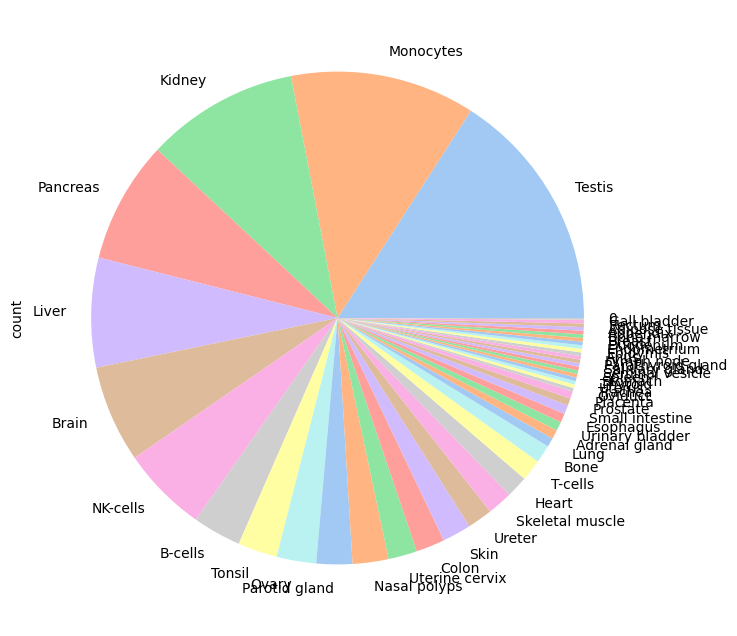

In [151]:
color = sns.color_palette('pastel')
atlas['tissue_name'].value_counts().plot.pie(figsize=(8,8),colors=color)

If we want to train a robust model, we need sufficient data to train on. Therefore we will drop the tissues that are represented by less than three samples.

In [152]:
tissue_counts[tissue_counts <= 3].index

Index([          'Oviduct',           'Trachea',            'Uterus',
                 'Thyroid',           'Stomach',            'Spleen',
         'Seminal vesicle',    'Salivary gland', 'Parathyroid gland',
              'Lymph node',              'Anus',          'Epidymis',
             'Endometrium',          'Duodenum',            'Breast',
             'Bone marrow',          'Appendix',    'Adipose tissue',
                  'Rectum',      'Gall bladder',                   0],
      dtype='object', name='tissue_name')

In [153]:
low_tissues = tissue_counts[tissue_counts <= 3].index
atlas = atlas[~atlas['tissue_name'].isin(low_tissues)]

Now we dropped some rows with e.g. Trachea. However, the proteins that are only found in Trachea are still in the dataframe but these will be zero in all the other classes. This means that they no longer add any information to our dataset and should be removed.

In [154]:
print(f"Before the removal our atlas had a shape of {atlas.shape}")
atlas = atlas.loc[:, (atlas != 0).any(axis=0)]
print(f"Now the shape is: {atlas.shape}")

Before the removal our atlas had a shape of (808, 11789)
Now the shape is: (808, 11106)


Which column was dropped that you did not expect?

In [155]:
#the fluid column

## Train and test split  
To train a machine learning model, we follow these key steps:

1. Split the data into features (X) and labels (y):
  Features (X) are the input variables used to make predictions, and in our case, these are the columns containing protein quantification values. The labels (y) are the target variable we want to predict, which in this case is the tissue type (tissue_name column).

2. Divide the data into a training set and a test set:
  The training set is used to train the model, while the test set is kept separate to evaluate how well the model performs on unseen data. The idea is to check how well the model generalizes beyond the data it was trained on. If the model performs well on the training set but poorly on the test set, this could indicate **overfitting** where the model has learned the specific details of the training data too well and fails to perform on new data.

In [156]:
atlas.head()

,A0A024RBG1,A0A075B6H7,A0A075B6H8,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I9,A0A075B6J6,A0A075B6J9,A0A075B6K0,...,Q9Y6Y0,Q9Y6Y8,Q9Y6Y9,Q9Y6Z4,Q9Y6Z5,Q9Y6Z7,W5XKT8,cell_type,tissue_name,disease_status
0,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,...,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,Brain,Brain,Healthy
1,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,...,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,Brain,Brain,Healthy
2,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,...,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,Brain,Brain,Healthy
3,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,...,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,Brain,Brain,Healthy
4,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,...,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,Brain,Brain,Healthy


In [157]:
X = atlas.iloc[:, :-3] #why do we slice and not take the last three columns?
y = atlas[['tissue_name']]


Splitting the X and y into a train and a test set is easily done with the train_test_split functionality from sklearn. The most used ratio is 20% test data, 80% training data.  

Keep in mind that you're working with an imbalanced dataset. Therefore, you should use the stratify function which will maintain the class proportions in train and test set, similar to the original data.

In [158]:
X

,A0A024RBG1,A0A075B6H7,A0A075B6H8,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I9,A0A075B6J6,A0A075B6J9,A0A075B6K0,...,Q9Y6X5,Q9Y6X8,Q9Y6X9,Q9Y6Y0,Q9Y6Y8,Q9Y6Y9,Q9Y6Z4,Q9Y6Z5,Q9Y6Z7,W5XKT8
0,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,...,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000
1,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,...,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000
2,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,...,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000
3,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,...,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000
4,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,...,0.00022419,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1045,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,...,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000
1046,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,...,0.00000000,0.00020419,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000
1047,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,...,0.00000000,0.00008243,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000
1048,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,...,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000


In [159]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

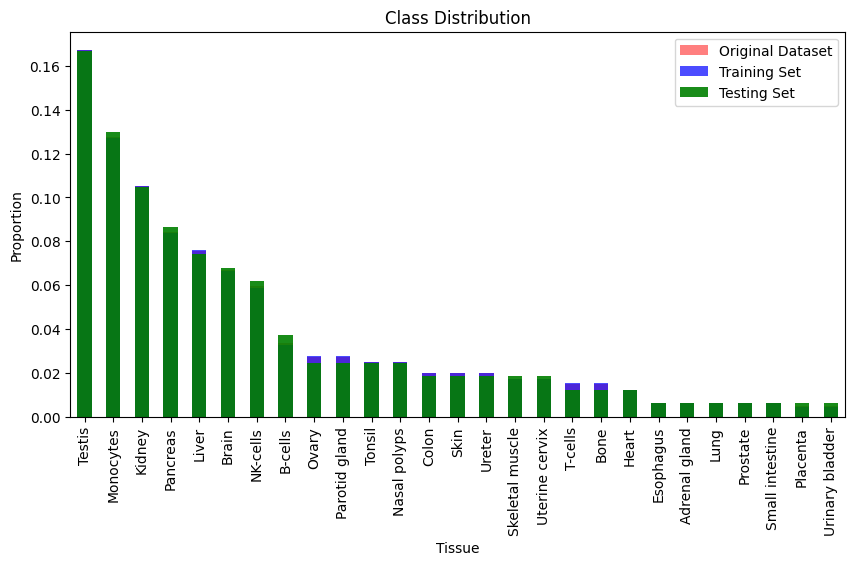

In [160]:
#Let's compare the class distribution in the entire, train and test data
class_distribution_original = y['tissue_name'].value_counts(normalize=True)
class_distribution_train = y_train['tissue_name'].value_counts(normalize=True)
class_distribution_test = y_test['tissue_name'].value_counts(normalize=True)

# Plot class distribution
plt.figure(figsize=(10, 5))
class_distribution_original.plot(kind='bar', alpha=0.5, label='Original Dataset', color='red')
class_distribution_train.plot(kind='bar', alpha=0.7, label='Training Set', color ='blue')
class_distribution_test.plot(kind='bar', alpha=0.9, label='Testing Set', color='green')
plt.title('Class Distribution')
plt.xlabel('Tissue')
plt.ylabel('Proportion')
plt.legend()
plt.show()

#this is almost identical, as there are sometimes uneven classes that are not possible to split 20/80 and we cannot cut a sample in half, there is a minor deviation


There exists a myriad of different ML models that can be used. In this case, we are looking at models that are capable to do multi-class classifications, we have a lot of different tissues to work with.
Let's take a look at four distinct models:

**Random Forest:**  
Random Forest is a machine learning method that creates many decision trees during training. Each tree is trained on different parts of the data and makes its own prediction. For multiclass classification, the algorithm combines the predictions from all the trees and chooses the class that most trees agree on. This approach reduces the chance of errors, making the final prediction more accurate.

**XGBoost:**  
XGBoost is a boosting algorithm that improves predictions by building decision trees sequentially. Each new tree focuses on correcting the errors made by the previous trees. In multiclass classification, XGBoost assigns probabilities to each class and selects the class with the highest probability. It is known for being very fast and accurate because it carefully optimizes each step of the learning process.

**Logistic Regression:**  
Logistic Regression is a simple algorithm that predicts the probability of an outcome based on input features. In multiclass classification, it calculates a separate probability for each possible class. The model then assigns the class with the highest probability to the data point. While it's straightforward and easy to understand, it works best when the data is linearly separable (can be divided clearly with a straight line).

**Support Vector Machine (SVM):**  
Support Vector Machine (SVM) finds the boundary (called a hyperplane) that best separates different classes of data. It tries to maximize the distance between this boundary and the closest data points from any class. For multiclass classification, SVM typically builds multiple models to handle more than two classes and then combines these models to make a final prediction. It’s effective for both linear and non-linear data, especially when there’s a clear margin between classes.  

**Training a model is one thing, but how do we evaluate it's performance? These are several metrics that are often used:**  


Accuracy:  
Accuracy measures how many predictions the model got correct overall. It’s calculated by dividing the number of correct predictions by the total number of predictions. While this is useful, it can be misleading in cases where some classes have much more data than others. For example, if most samples belong to one class, a model can achieve high accuracy by simply predicting that class most of the time, ignoring minority classes.

Precision:  
Precision focuses on how often the model’s positive predictions are actually correct. It’s the ratio of true positive predictions to all positive predictions (true positives + false positives). In other words, it answers the question: "When the model predicts a certain class, how often is it right?"

Recall (Sensitivity):  
Recall tells us how well the model captures all the positive cases in the data. It’s the ratio of true positives to all actual positive cases (true positives + false negatives). This metric answers: "Of all the actual instances of a class, how many did the model correctly identify?" High recall means the model is catching most of the relevant cases, but it might also pick up false positives.

F1-Score:  
The F1-score combines precision and recall into a single number by taking their harmonic mean. It’s useful when we want to balance precision and recall. An F1-score close to 1 means the model has both high precision and recall, while a low score indicates a trade-off between them.

Let's start with RandomForest

## Training and evaluating a model

In [161]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier() # we initiatie the model
rf_model.fit(X_train, y_train) # fit on the training data
y_pred = rf_model.predict(X_test) # based on the proteins in the test data, make a prediction
# Compare the predicted tissues to the real tissues of the test set
# Calculate accuracy, precision, recall, and F1-score to assess performance
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

# Print the results
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Accuracy: 0.9259259259259259
Precision: 0.7223251028806585
Recall: 0.7424554183813442
F1-score: 0.7311784560703961


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


What seems like the best metric to use for performanc evaluation to you?

Its easier to visualise this through a confusion matrix

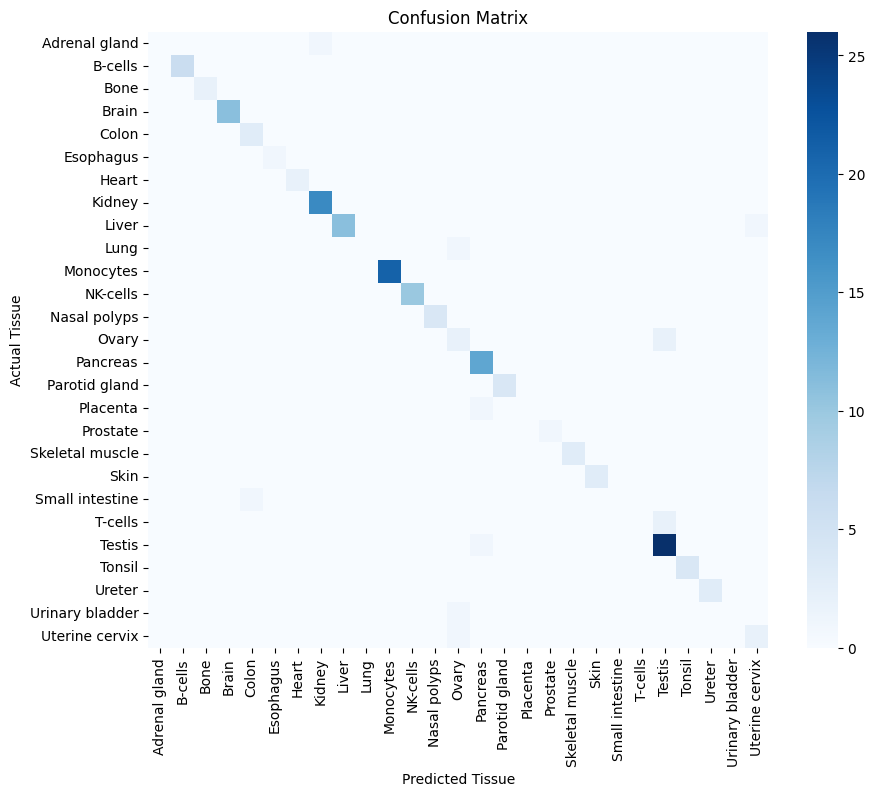

In [162]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

tissue_names = sorted(y_test['tissue_name'].unique())

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=tissue_names)

# Plot the confusion matrix with colors and labels
plt.figure(figsize=(10, 8))
sns.heatmap(cm, cmap='Blues', xticklabels=tissue_names, yticklabels=tissue_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Tissue')
plt.ylabel('Actual Tissue')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()

Can you do this for the other models as well?  


In [163]:
#necessary packages
# Logistic Regression
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import LabelEncoder


This can take quite a while...

In [135]:
# Define models
models = {
    "Random Forest": RandomForestClassifier(),
    "XGBoost": XGBClassifier(),
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "SVM": SVC(),
}

# Define metrics
metrics = ["Accuracy", "Precision", "Recall", "F1-score"]

# Create an empty list to store results
results = []

# Loop through models
for model_name, model in models.items():
    # Initialize LabelEncoder if model is XGBoost
    if model_name == "XGBoost":
        le = LabelEncoder()
        y_train_encoded = le.fit_transform(y_train)
        y_test_encoded = le.transform(y_test)

        # Fit the model on encoded labels
        model.fit(X_train, y_train_encoded)

        # Predict on encoded test data
        y_pred = model.predict(X_test)

        # Inverse transform predictions for evaluation
        y_pred = le.inverse_transform(y_pred)
    else:
        # Fit the model
        model.fit(X_train, y_train)

        # Predict on test data
        y_pred = model.predict(X_test)

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='macro')
    recall = recall_score(y_test, y_pred, average='macro')
    f1 = f1_score(y_test, y_pred, average='macro')

    # Store results
    results.append([model_name, accuracy, precision, recall, f1])

# Create a DataFrame from results
results_df = pd.DataFrame(results, columns=["Model", "Accuracy", "Precision", "Recall", "F1-score"])

# Print the results
print(results_df)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was exp

                 Model   Accuracy  Precision     Recall   F1-score
0        Random Forest 0.94047619 0.81319444 0.82308201 0.81300145
1              XGBoost 0.93452381 0.90141294 0.89318783 0.88540628
2  Logistic Regression 0.33333333 0.14518318 0.11302021 0.09546324
3                  SVM 0.77380952 0.60147392 0.53616189 0.53881473


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


The results are stored in the results_df dataframe. Let's make a visual comparison

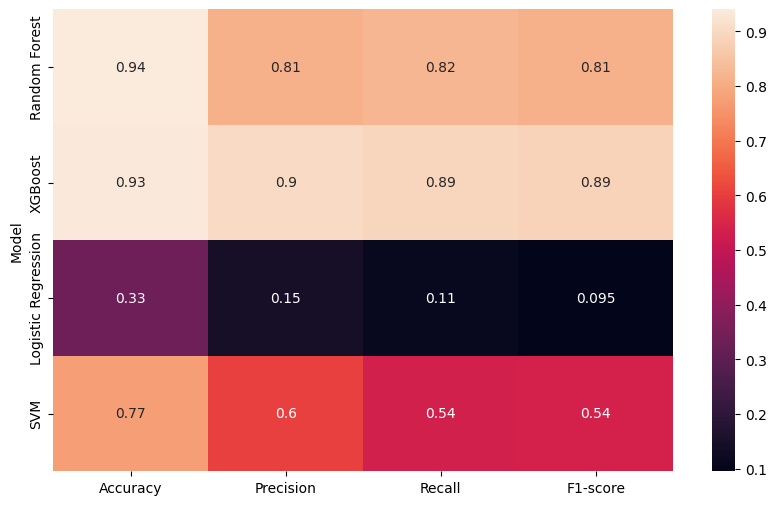

In [136]:
fig, ax = plt.subplots(figsize=(10, 6))
ax = sns.heatmap(results_df.set_index('Model'), annot=True)

What is the best model?  
Can you explain why the performance is so drastically different between different model types?

## Hyperparameter tuning  

Hyperparameter tuning is the process of optimizing the settings that control how a machine learning model learns from data. These parameters (like learning rate, number of trees, or regularization strength) are not learned from the data itself but must be set beforehand.

Tuning is necessary to improve model performance, prevent overfitting or underfitting, and ensure the model generalizes well to unseen data. Methods like grid search or random search help us find the best combination of hyperparameters, allowing the model to perform optimally on the specific dataset.  

**Cross-validation**   
Cross-validation is a technique used to assess the performance of a machine learning model by splitting the dataset into several subsets (or "folds"). The model is trained on some of these folds and tested on the remaining fold, rotating the process so each fold is used as a test set once. This helps ensure that the model’s performance is evaluated across different parts of the data, giving a more reliable estimate than a single train-test split. Cross-validation is especially useful during hyperparameter tuning to avoid overfitting and ensure the model generalizes well. Common methods include k-fold cross-validation, where the data is split into k equally sized folds.

In [ ]:
#a variety of hyperparameters to test
n_estimators = [500,600,650,700]
max_features = ['sqrt']
max_depth = [50,70,90]
min_samples_split = [1,15,20,30]
min_samples_leaf = [1,2]
bootstrap = [False]
param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
#initiate the RF
rf = RandomForestClassifier()
gs = GridSearchCV(rf,
param_grid,
cv=3, #why do we put cross_validation= 3?
verbose=2,
n_jobs=-1)

gs.fit(X_train, y_train)
gs.best_params_

Fitting 3 folds for each of 96 candidates, totalling 288 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
72 fits failed out of a total of 288.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
72 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1466, in wrapper
    estimator._validate_params()
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/utils/

{'bootstrap': False,
 'max_depth': 90,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 15,
 'n_estimators': 600}

In [164]:
rf_optimized = RandomForestClassifier(n_estimators=600, max_depth=90, max_features='sqrt', bootstrap=False,
    min_samples_leaf=1, min_samples_split=15, random_state=42, class_weight='balanced', n_jobs=-1) # we initiatie the model
rf_optimized.fit(X_train, y_train) # fit on the training data
y_pred = rf_optimized.predict(X_test) # based on the proteins in the test data, make a prediction
# Compare the predicted tissues to the real tissues of the test set
#Calculate accuracy, precision, recall, and F1-score to assess performance
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')
# Print the results
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Accuracy: 0.9506172839506173
Precision: 0.9441309033901627
Recall: 0.9601321860581119
F1-score: 0.9406772278330652


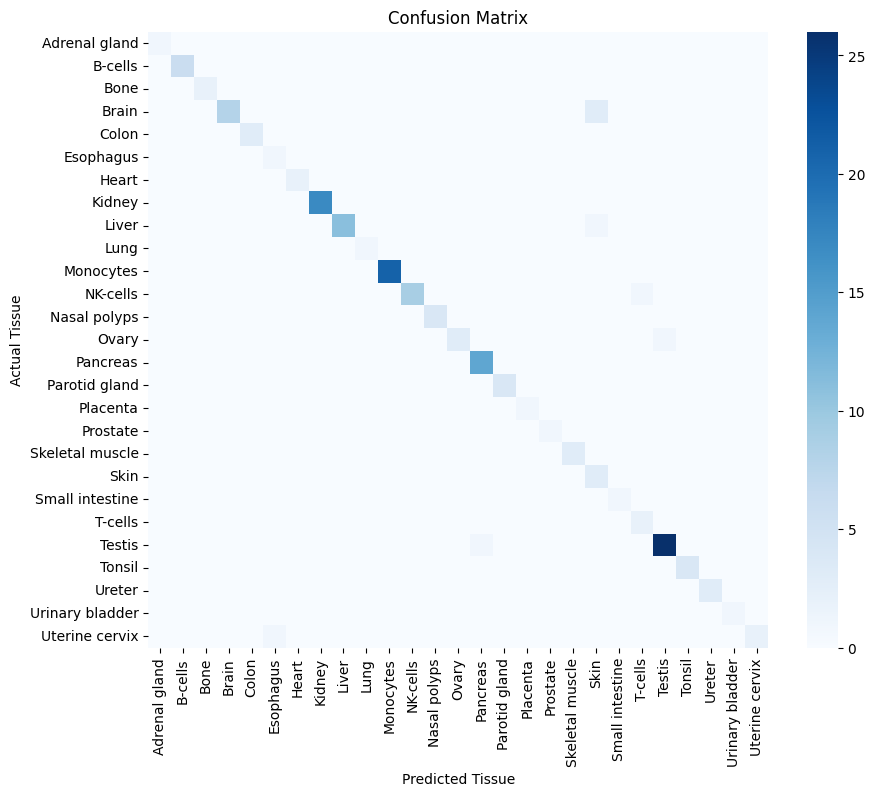

In [165]:
tissue_names = sorted(y_test['tissue_name'].unique())

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=tissue_names)

# Plot the confusion matrix with colors and labels
plt.figure(figsize=(10, 8))
sns.heatmap(cm, cmap='Blues', xticklabels=tissue_names, yticklabels=tissue_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Tissue')
plt.ylabel('Actual Tissue')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()

## Biological analysis by studying the features

The RandomForest has a built in option that studies feature importance. Every feature gets a score based on the impact it has on the tree. However, as a RandomForest contains a large number of trees, this importance per feature can be a little different. Therefore the standard deviation is also important across trees.  

Important to note here is that a RandomForest will also use the absence of a feature to be important.

In [166]:
importances = rf_optimized.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf_optimized.estimators_],axis=0) #compute standard deviation of the feature importance over all the DecisionTreeClassifiers in the Random rf_optimized
feature_names = X.columns
rf_features_df = pd.DataFrame(columns=['feature_name', 'importance', 'standard deviation'])
for f in range(X.shape[1]-1):
    rf_features_df.loc[f] = [feature_names[f], importances[f], std[f]]
pd.set_option('display.float_format', lambda x: '%.8f' % x)

rf_features_df.sort_values(['importance'], axis=0, ascending=False)

,feature_name,importance,standard deviation
3066,P49221,0.00438083,0.01311579
2024,P11678,0.00428301,0.01285557
9410,Q9H987,0.00401474,0.01211389
2101,P13796,0.00386963,0.01018941
4147,Q13751,0.00372115,0.01188437
...,...,...,...
5376,Q6DN14,0.00000000,0.00000000
5374,Q6DKK2,0.00000000,0.00000000
5370,Q6DJT9,0.00000000,0.00000000
5368,Q6DHV5,0.00000000,0.00000000


How many features have an importance of zero?  
Is this what you would expect?  
What does that mean for the model?  


In [167]:
rf_features_df[rf_features_df['importance'] == 0].shape

(5918, 3)

# Apply it onto diseased data  

A model is only as good as its applications. Let's apply it onto a diseased sample and see how the prediction changes.

In [194]:
diseased_atlas = pd.read_csv('/content/data/tissue_predictor_diseased_nofluid.csv')
diseased_atlas.head()

,A0A024RBG1,A0A075B6H7,A0A075B6H8,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I7,A0A075B6I9,A0A075B6J1,A0A075B6J6,...,Q9Y6Y8,Q9Y6Y9,Q9Y6Z4,Q9Y6Z5,Q9Y6Z7,W5XKT8,cell_type,tissue_name,disease_status,fluid
0,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,...,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,Liver,Liver,Cell culture,0.00000000
1,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,...,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,Liver,Liver,Cell culture,0.00000000
2,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,...,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,Liver,Liver,Cell culture,0.00000000
3,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,...,0.00062623,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,Liver,Liver,Cell culture,0.00000000
4,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,...,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,Liver,Liver,Cell culture,0.00000000


In [195]:
diseased_atlas = diseased_atlas[(diseased_atlas['disease_status'] != 'Healthy') & (diseased_atlas['tissue_name'] != 'Unknown')]
diseased_atlas = diseased_atlas[~diseased_atlas['disease_status'].isin(['Healthy', 'Unknown', 'Extracellular vesicles of the tissue were isolated', 'No distinct annotation', 'no distinct annotation', 'nan', 'Cell culture', 'Cell culture + cancer'])]
diseased_atlas.disease_status.unique()

array(['Cancer', 'Diseased', nan], dtype=object)

In [196]:
# the model can only use features it was trained upon
trained_features = rf_optimized.feature_names_in_
trained_features = np.append(trained_features, 'tissue_name')
diseased_atlas = diseased_atlas[trained_features]

With the predict function, we get the most likely predicted tissue. If we use predict_proba we also get a probability value for the prediction

In [200]:
diseased_atlas.tissue_name.unique()

array(['Breast', 'Lung', 'Synovial tissue', 'Colon', 'Liver', 'Skin',
       'Brain', 'Urinary bladder', 'Kidney', 'Heart', nan], dtype=object)

Let's test some kidney samples

In [226]:
kidney_test = diseased_atlas[diseased_atlas['tissue_name'] == 'Kidney']
kidney_test.shape



(40, 11104)

In [227]:
for i in range(kidney_test.shape[0]):
  test_sample = kidney_test.iloc[i:i+1, :-1]
  predicted_tissue = rf_optimized.predict(test_sample)
  print(predicted_tissue)

['Testis']
['Testis']
['Testis']
['Kidney']
['Testis']
['Testis']
['Testis']
['Kidney']
['Testis']
['Testis']
['Testis']
['Kidney']
['Kidney']
['Testis']
['Testis']
['Testis']
['Testis']
['Testis']
['Testis']
['Kidney']
['Testis']
['Testis']
['Kidney']
['Testis']
['Testis']
['Testis']
['Testis']
['Testis']
['Testis']
['Testis']
['Kidney']
['Testis']
['Testis']
['Testis']
['Testis']
['Testis']
['Testis']
['Testis']
['Testis']
['Testis']


We can see a lot of confusion between Kidney and Testis. But if we use predict_proba, what is the top 5 of likely tissues?  
Predict_proba outputs just an array of probability values, each value belongs to one of the classes the model was trained upon (in the model.classes_ functionality you can see how they are ordered)

Let's make an overview

In [228]:
rf_optimized.classes_

array(['Adrenal gland', 'B-cells', 'Bone', 'Brain', 'Colon', 'Esophagus',
       'Heart', 'Kidney', 'Liver', 'Lung', 'Monocytes', 'NK-cells',
       'Nasal polyps', 'Ovary', 'Pancreas', 'Parotid gland', 'Placenta',
       'Prostate', 'Skeletal muscle', 'Skin', 'Small intestine',
       'T-cells', 'Testis', 'Tonsil', 'Ureter', 'Urinary bladder',
       'Uterine cervix'], dtype=object)

In [229]:
rf_optimized.predict_proba(test_sample)

array([[0.00983867, 0.0429968 , 0.00456012, 0.02520833, 0.02982772,
        0.00119469, 0.00544296, 0.16185776, 0.11715212, 0.05839191,
        0.03786923, 0.03407398, 0.00264631, 0.04219733, 0.05157654,
        0.01447147, 0.02040971, 0.01797197, 0.00592617, 0.00565565,
        0.0249965 , 0.06077778, 0.16404454, 0.02365022, 0.01807654,
        0.01360569, 0.00557929]])

In [230]:
# Create an empty list to store the probabilities
probabilities = []

# Iterate over each sample in kidney_test
for i in range(kidney_test.shape[0]):
  test_sample = kidney_test.iloc[i:i+1, :-1]
  # Predict probabilities for each class
  predicted_probabilities = rf_optimized.predict_proba(test_sample)
  probabilities.append(predicted_probabilities[0])  # Get probabilities for the sample, it is a nested list

# Get the tissue names from the model to use as column names in
tissue_names = rf_optimized.classes_

# Create a DataFrame from the probabilities
probability_df = pd.DataFrame(probabilities, columns=tissue_names)

<Axes: >

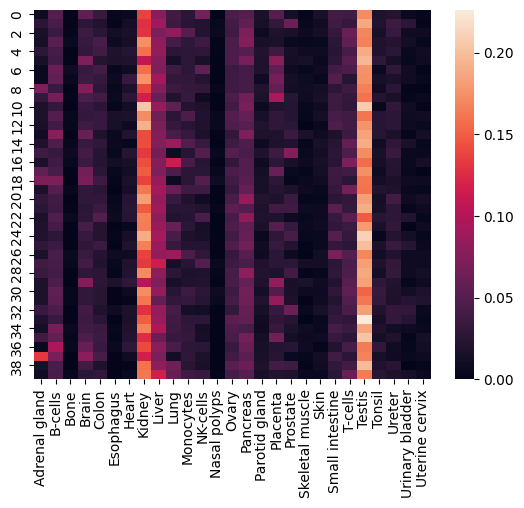

In [231]:
sns.heatmap(probability_df, annot=False)

# Exercises:  
1. Feature reduction:
  Try feature reduction approaches like mutual information, entropy, recursive feature selection etc. and see the impact on the models performance. What is the minimal set of features while maintaining decent performance?
2. What is the difference in feature importance between XGBoost and RandomForest? Compare feature importance spread, number of zero values etc.
3. Assess the impact of missing values in the data.
4. Play around with applying the model onto the diseased data. Are there drastic differences between samples and types of diseases (cancer, cell culture, etc.)?
5. How can you know that the model is using the absence of a protein in its prediction?